# SIMULACION MONTE CARLO

## Importación de librerias

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import os
from datetime import datetime
import time

## Configuración del entorno de simulación

**Objetivo:** Ejecutar el motor estocástico vectorizado usando parámetros calibrados.

In [ ]:
# Configuración Visual
plt.style.use('seaborn-v0_8-darkgrid')
np.random.seed(42) # Semilla para reproducibilidad inicial

# Definición de Rutas (Arquitectura Hexagonal: Input desde capa Parameters)
BASE_DIR = os.getcwd() # Se asume que corre desde la raíz o ajusta con "../"
if os.path.basename(BASE_DIR) == "notebooks":
    BASE_DIR = os.path.dirname(BASE_DIR) # Subir un nivel si esta en notebooks/

CONFIG_FILE = os.path.join(BASE_DIR, "risk_engine_config.json")

print(f"⚙️ Entorno configurado. Directorio base: {BASE_DIR}")

⚙️ Entorno configurado. Directorio base: /home/puya-chilensis/CL-RiskEngine


## Ingesta de parámetros calibrados (Json)

In [6]:
# Lectura del artefacto generado en la fase de EDA.

print(f"📖 Leyendo configuración desde: {CONFIG_FILE}")

try:
    with open(CONFIG_FILE, 'r') as f:
        config_data = json.load(f)
        
    # Extracción de Tensores Matemáticos
    # Nota: JSON no tiene arrays de numpy, hay que convertirlos.
    MU_VECTOR = np.array(config_data["model_params"]["mu_vector"])
    COV_MATRIX = np.array(config_data["model_params"]["cov_matrix"])
    CHOLESKY_L = np.array(config_data["model_params"]["cholesky_L"])
    
    # Metadatos
    ACTIVOS = config_data["metadata"]["activos"]
    DIAS_TRADING = config_data["metadata"]["dias_bursatiles"]
    NU_PARAMS = config_data["model_params"]["t_student_nu"] # Los famosos grados de libertad
    
    # Validaciones de Integridad
    assert len(ACTIVOS) == len(MU_VECTOR), "❌ Error de dimensión: Activos vs Medias"
    assert CHOLESKY_L.shape[0] == len(ACTIVOS), "❌ Error de dimensión: Cholesky vs Activos"
    
    print("✅ Parámetros cargados exitosamente en memoria.")
    print(f"   🔹 Activos: {ACTIVOS}")
    print(f"   🔹 Horizonte Temporal Base (T): {DIAS_TRADING} días")
    print(f"   🔹 Matriz de Correlación Inducida (L): {CHOLESKY_L.shape}")
    print(f"   🔹 Parámetros de Cola (Nu): Disponible para {len(NU_PARAMS)} activos")

except FileNotFoundError:
    print("❌ ERROR: No se encuentra risk_engine_config.json.")
    print("   Solución: Ejecuta el Notebook 01 completamente para generar la calibración.")
except Exception as e:
    print(f"❌ Error crítico leyendo JSON: {e}")

📖 Leyendo configuración desde: /home/puya-chilensis/CL-RiskEngine/risk_engine_config.json
✅ Parámetros cargados exitosamente en memoria.
   🔹 Activos: ['CHILE.SN', 'COPEC.SN', 'SQM-B.SN', '^GSPC', 'UF', 'USD_OBS']
   🔹 Horizonte Temporal Base (T): 252 días
   🔹 Matriz de Correlación Inducida (L): (6, 6)
   🔹 Parámetros de Cola (Nu): Disponible para 6 activos


## MOTOR DE SIMULACIÓN VECTORIZADO (CORE)

**Objetivo:** Clase que encapsula la lógica GBM y t-Student Shocks.

In [7]:
class MonteCarloEngine:
    def __init__(self, mu, cholesky_matrix, nu_params, dt=1/252):
        """
        Inicializa el motor con los parámetros de mercado calibrados.
        :param mu: Vector de medias anualizadas (numpy array)
        :param cholesky_matrix: Matriz L triangular inferior (numpy array)
        :param nu_params: Diccionario {activo: grados_libertad}
        :param dt: Paso de tiempo (diario = 1/252)
        """
        self.mu = mu
        self.L = cholesky_matrix
        self.nu_params = np.array(list(nu_params.values())) # transformacion array ordenado
        self.dt = dt
        self.n_assets = len(mu)
        
    def generate_correlated_shocks(self, n_sims, n_steps, method='normal'):
        """
        Genera la matriz de ruido aleatorio Z correlacionada.
        Shape de salida: (n_steps, n_sims, n_assets)
        """
        print(f"   ⚡ Generando {n_sims * n_steps} choques estocásticos (Modo: {method.upper()})...")
        
        # 1. Generación de Ruido Independiente (Raw Noise)
        if method == 'normal':
            # Z ~ N(0, 1)
            raw_noise = np.random.normal(0, 1, size=(n_steps, n_sims, self.n_assets))
            
        elif method == 't-student':
            # Z ~ t(nu) estandarizada
            # Paso A: Generar t-Student pura para cada activo según su nu
            raw_noise = np.zeros((n_steps, n_sims, self.n_assets))
            
            for i in range(self.n_assets):
                nu_i = self.nu_params[i]
                # "Floor" de seguridad para evitar varianza infinita si nu < 2.5
                effective_nu = max(nu_i, 2.5) 
                
                # Generamos t-student
                t_samples = np.random.standard_t(effective_nu, size=(n_steps, n_sims))
                
                # Paso B: Normalización de Varianza (Vital para no romper la escala)
                # std_t = sqrt(nu / (nu - 2))
                scaling_factor = np.sqrt(effective_nu / (effective_nu - 2))
                z_standardized = t_samples / scaling_factor
                
                raw_noise[:, :, i] = z_standardized
        
        else:
            raise ValueError("Método no soportado. Use 'normal' o 't-student'.")

        # 2. Inducción de Correlación (Cholesky)
        # Matemáticamente: Z_corr = Z_raw @ L.T
        # Usamos einsum para optimizar la multiplicación de tensores (High Speed)
        # "t s a, b a -> t s b" significa: (tiempo, sim, activo_in) x (activo_out, activo_in)
        correlated_shocks = np.einsum('tsa,ba->tsb', raw_noise, self.L)
        
        return correlated_shocks

    def simulate(self, S0, n_sims, n_steps, method='normal'):
        """
        Se ejecuta la evolución de precios completa.
        dS = S * (mu*dt + sigma*dZ) -> Solución Exacta Exponencial
        """
        # Matriz para guardar precios: (n_steps + 1, n_sims, n_assets)
        prices = np.zeros((n_steps + 1, n_sims, self.n_assets))
        prices[0] = S0 # Condición inicial
        
        # produccion de los choques correlacionados
        Z_corr = self.generate_correlated_shocks(n_sims, n_steps, method)
        
        # Pre-cálculo del Drift determinístico (Itô correction)
        # drift = (mu - 0.5 * sigma^2) * dt
        # Ojo: Aquí sigma^2 es la varianza (diagonal de la covarianza)
        # Recuperacion sigma implícita desde Cholesky: Sigma = L @ L.T
        cov_recon = self.L @ self.L.T
        variances = np.diag(cov_recon)
        drift = (self.mu - 0.5 * variances) * self.dt
        
        # Loop temporal (Evolución)
        # Nota: Vectorizado por sims y activos, solo iteracion en el tiempo
        for t in range(n_steps):
            # S_t = S_{t-1} * exp(drift + diffusion)
            diffusion = Z_corr[t] * np.sqrt(self.dt) # Z * sqrt(dt) es el movimiento Browniano
            
            # Actualización
            prices[t+1] = prices[t] * np.exp(drift + diffusion)
            
        return prices

print("✅ Motor de Monte Carlo 'Ready-to-Run' definido en memoria.")

✅ Motor de Monte Carlo 'Ready-to-Run' definido en memoria.


## EJECUCIÓN DE ESCENARIOS (BASE 100)

**Simulación de estrés:** 1,000 escenarios x 252 días

### Parametros de ejecución

In [8]:
N_SIMS = 1000       # Cantidad de universos paralelos (puedes subir a 10,000 si tienes RAM)
HORIZONTE = 252     # 1 año bursátil
S0_BASE = 100.0     # Todos los activos empiezan en 100 (para comparar)
# Vector de precios iniciales (Todos 100)
S0_vector = np.full(len(ACTIVOS), S0_BASE)

### Inicialización del motor

In [9]:
mc_engine = MonteCarloEngine(MU_VECTOR, CHOLESKY_L, NU_PARAMS)

### Correr simulación (Modo: T-Student robusto)

In [10]:
# uso de 't-student' para que los datos muestren colas gordas.
start_time = time.time()
paths = mc_engine.simulate(S0_vector, N_SIMS, HORIZONTE, method='t-student')
exec_time = time.time() - start_time

print("-" * 50)
print(f"🚀 SIMULACIÓN COMPLETADA EN {exec_time:.2f} SEGUNDOS")
print(f"   🌌 Dimensiones del Cubo de Datos: {paths.shape}")
print(f"   (Días={paths.shape[0]}, Sims={paths.shape[1]}, Activos={paths.shape[2]})")
print("-" * 50)

   ⚡ Generando 252000 choques estocásticos (Modo: T-STUDENT)...
--------------------------------------------------
🚀 SIMULACIÓN COMPLETADA EN 0.16 SEGUNDOS
   🌌 Dimensiones del Cubo de Datos: (253, 1000, 6)
   (Días=253, Sims=1000, Activos=6)
--------------------------------------------------


### Visualización rápida (Spaghetti plot)

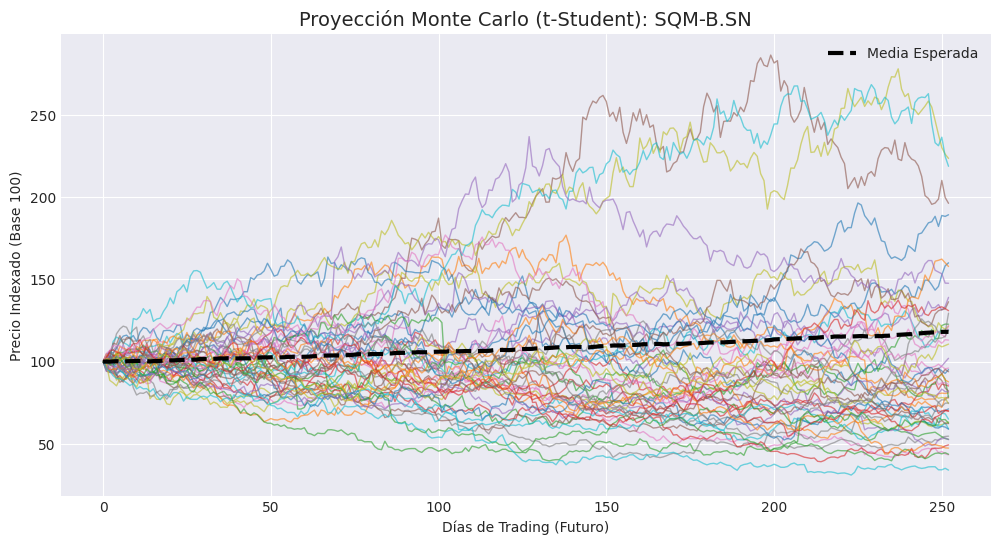

In [11]:
# Graficar solo los primeros 50 escenarios del activo más volátil (ej: SQM o S&P500)
# Buscar el índice de SQM o ^GSPC
idx_plot = 2 # Por defecto el 3ero, ajusta según tu lista de activos
nombre_activo = ACTIVOS[idx_plot]

plt.figure(figsize=(12, 6))
plt.plot(paths[:, :50, idx_plot], lw=1, alpha=0.6) # Solo 50 caminos
plt.plot(paths[:, :, idx_plot].mean(axis=1), 'k--', lw=3, label='Media Esperada') # Media de todo
plt.title(f"Proyección Monte Carlo (t-Student): {nombre_activo}", fontsize=14)
plt.xlabel("Días de Trading (Futuro)")
plt.ylabel("Precio Indexado (Base 100)")
plt.legend()
plt.show()